<a href="https://colab.research.google.com/github/SudeepSarkar/sarkar-computer-vision-lectures/blob/main/CV_Module_4_1_Image_Pyramid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) 2021, Sudeep Sarkar, University of South Florida, Tampa

The above figure is from the textbook Computer Vision: Algorithms and Applications 2nd Edition Richard Szeliski - (c) 2022 Springer

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io
from skimage.color import rgb2gray, rgba2rgb

from scipy import ndimage as scimage
import scipy.ndimage as scimage
# SciPy (pronounced “Sigh Pie”) is a Python-based ecosystem of open-source software for mathematics, science, and engineering.
# https://www.scipy.org/

np.set_printoptions(precision=2)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/Colab Notebooks/CAP 6415 Computer Vision Online/data/'
data_dir = '/content/drive/MyDrive/Colab Notebooks/CAP 6415 Computer Vision Online/data/'

Mounted at /content/drive
 apple.jpg				     Fig3_4c.jpg     solution2.png
'Armes 1.png'				     house_1.png     solution3.png
 declaration_of_independence_stone_630.jpg   house_2.png     Walton_NFC.zip
 Fig3_3a.jpg				     lizard.jpg
 Fig3_4a.jpg				     solution1.png


In [33]:
def padded_add(a, b):
    # Returns the addition of arrays a and b, which can be of different sizes.
    # We pad a and b with additional zero-valued rows and columns to make them of the same size.
    # The output size is the maximum of two arrays.
    # You can use this to also subtract two arrays of different sizes -- just pass -b instead of b.

    h1, w1 = a.shape
    h2, w2 = b.shape
    h_max = max(h1, h2)
    w_max = max(w1, w2)

    a_padded = np.pad(a, ((0, h_max - h1), (0, w_max - w1)), 'constant')
    b_padded = np.pad(b, ((0, h_max - h2), (0, w_max - w2)), 'constant')

    return a_padded + b_padded

In [32]:
def scale_image (in_image, scale, sample_order):
    """
    Scales the size of an input image using a specified scale factor and order of spline interpolation.
    """
    height, width = in_image.shape
    height_out = int(height * scale)
    width_out = int(width * scale)
    out_image = np.zeros((height_out, width_out))

    y, x = np.meshgrid(np.arange(height_out), np.arange(width_out))
    fx = x/scale
    fy = y/scale
    values = scimage.map_coordinates(in_image, [fy, fx], order=sample_order)
    out_image[y, x] = values

    return out_image

# Assignment: Difference Pyramid

For an image in the collection provided for this course, construct two difference-pyramids. The first pyramid should have 4 levels and the second should have 8 levels. Analyze the results of each pyramid and discuss how you can utilize them to compress the image, i.e. reduce the file size of the image stored on disk. Submit your report on the Canvas platform.

### Code: (up) and (down) pyramids

In [64]:
def UpDownDifferencePyramid(num_levels = 4, factor = 2.0):
    # Create image (up) pyramid by downscaling the image by factor
    # The pyramid is stored as list:[I_0, I_1, ...., I_n] -- large to small sized.
    up_pyramid = []
    up_pyramid.append(img)
    for i in range (1, num_levels) :
        up_pyramid.append(scale_image (up_pyramid[-1], scale = 1/factor, sample_order = 1))

    # Create the down pyramid by upscaling from the top of the pyramid
    # The pyramid is stored as list:[J_n, J_(n-1), ...., J_0] -- small to large sized.
    down_pyramid = []
    down_pyramid.append(up_pyramid[-1])
    for i in range (1, num_levels) :
        down_pyramid.append(scale_image (up_pyramid[num_levels-i], scale = factor, sample_order = 1))

    # The Difference Pyramid is composed of the difference between the images at the
    # corresponding levels of the up- and down- pyramid, except for the top-most level,
    # which is the same as the top-most of the up-pyramid.

    difference_pyramid = []
    difference_pyramid.append(up_pyramid[-1])
    # The pyramid is stored as list:[D_n, D_(n-1), ...., D_0] -- small to large sized.
    for i in range (1, num_levels) :
        # compute error between the reconstructed images at each level from previous levels
        diff_im = padded_add (up_pyramid[-(i+1)], -down_pyramid[i])
        difference_pyramid.append(diff_im)

    return up_pyramid, down_pyramid, difference_pyramid


### Reconstructing the image

In [46]:
def Reconstruct(num_levels = 4, factor = 2.0, difference_pyramid = []):
    # Reconstruct the image up-pyramid
    # The reconstructed image up-pyramid is stored as list:[I_hat_n, I_hat_(n-1), ...., I_hat_0] -- small to large sized.
    I_hat_pyramid = []
    I_hat_pyramid.append(difference_pyramid[0])
    for i in range (1, num_levels) :
        up_scaled_im = scale_image(I_hat_pyramid[i-1], scale = factor, sample_order = 1)
        reconstructed_image = padded_add (up_scaled_im, difference_pyramid[i])
        I_hat_pyramid.append(reconstructed_image)

    return I_hat_pyramid

### Display

In [72]:
def DispayPyramidsAndHistogram(num_levels,up_pyramid,down_pyramid,difference_pyramid,I_hat_pyramid):
  #------------------display-----------------------------------------

  fig, axs = plt.subplots( nrows=num_levels, ncols=5) #, sharex=True, sharey=True)

  #fig.set_size_inches (20,20)
  fig.set_figwidth(20)

  if num_levels == 4:
    fig.set_figheight(13)
  elif num_levels == 8:
    fig.set_figheight(26)



  for i in range (num_levels) :
      axs[i, 0].imshow(up_pyramid[-(i+1)], 'gray')
      axs[i, 0].set_title('(Up) Pyramid level {}'.format(num_levels-i-1))

      axs[i, 1].imshow(down_pyramid[i], 'gray')
      axs[i, 1].set_title('(Down) Pyramid level {}'.format(num_levels-1-i))

      axs[i, 2].imshow(difference_pyramid[i], 'gray')
      axs[i, 2].set_title('Difference Pyramid Level ={}'.format(num_levels-i-1))

      axs[i, 3].hist((padded_add(up_pyramid[-(i+1)], -down_pyramid[i])).reshape(-1))
      axs[i, 3].set_title('Difference histogram ={}'.format(num_levels-i-1))

      axs[i, 4].imshow(I_hat_pyramid[i], 'gray')
      axs[i, 4].set_title('Reconstructed Level ={}'.format(num_levels-i-1))


---

# SOLUTION ASSIGNMENT

In [ ]:
from numpy.ma.core import shape
# Load an color image in grayscale
img = io.imread(data_dir+'Armes 1.png')
img = rgba2rgb(img)
img = rgb2gray(img)

## Pyramid 4 levels:

Up-pyramid Highest level shape (37, 50)
size:  1850


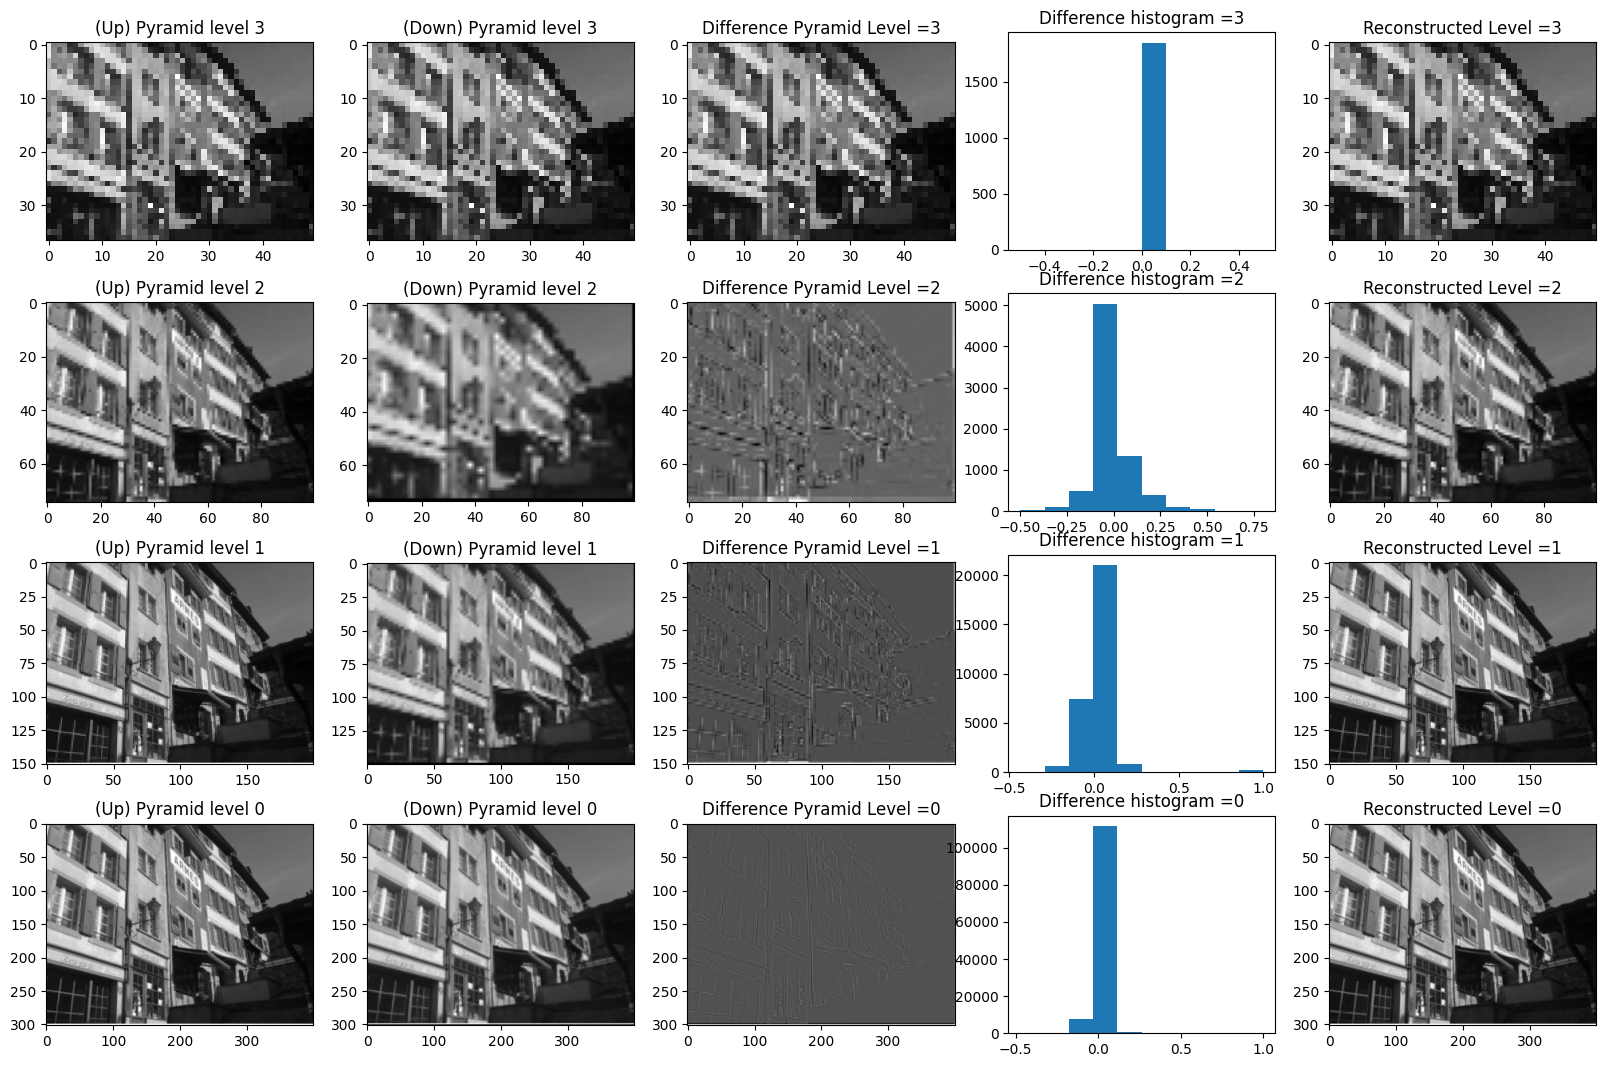

In [78]:
num_levels = 4
factor = 2.0

# Create Pyramids and their difference
up_pyramid, down_pyramid, difference_pyramid = UpDownDifferencePyramid(num_levels, factor)
print("Up-pyramid Highest level shape",up_pyramid[3].shape)
print("size: ", up_pyramid[3].shape[0]*up_pyramid[3].shape[1])

# Reconstruct
I_hat_pyramid = Reconstruct(num_levels, factor, difference_pyramid)

# Display
DispayPyramidsAndHistogram(num_levels,up_pyramid,down_pyramid,difference_pyramid,I_hat_pyramid)

## Pyramid 8 levels:

Up-pyramid Highest level shape (2, 3)
 size:  6


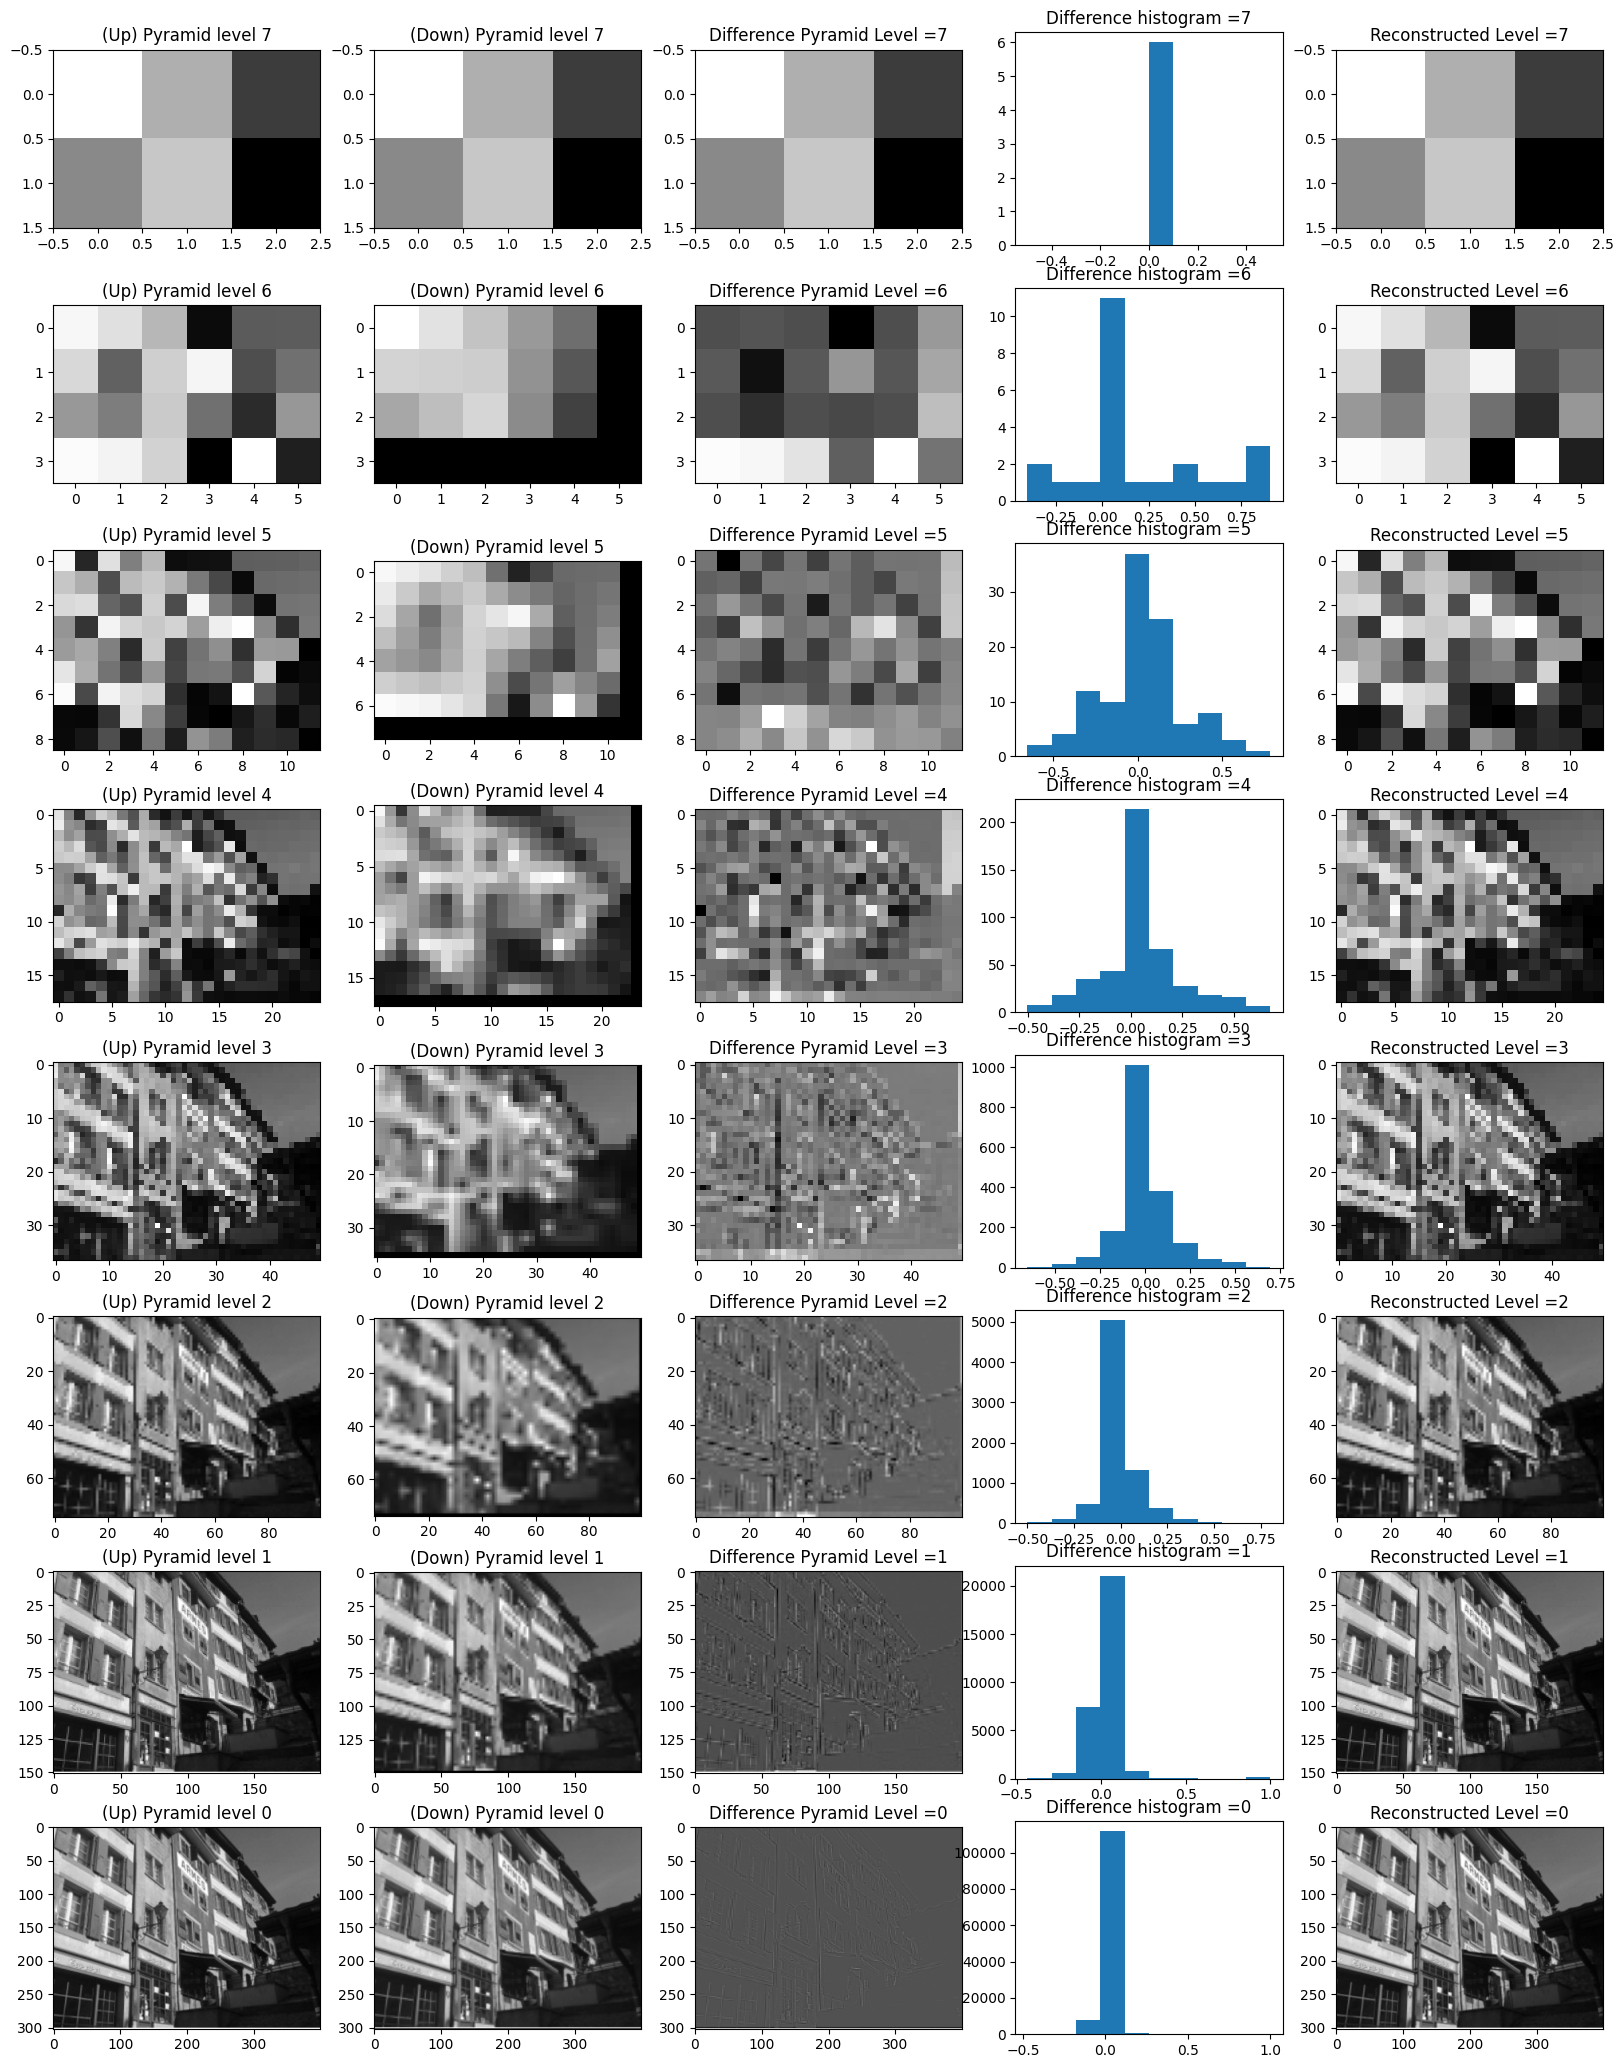

In [79]:
num_levels = 8
factor = 2.0

# Create Pyramids and their difference
up_pyramid, down_pyramid, difference_pyramid = UpDownDifferencePyramid(num_levels, factor)
print("Up-pyramid Highest level shape",up_pyramid[7].shape)
print("size: ", up_pyramid[7].shape[0]*up_pyramid[7].shape[1])

# Reconstruct
I_hat_pyramid = Reconstruct(num_levels, factor, difference_pyramid)

# Display
DispayPyramidsAndHistogram(num_levels,up_pyramid,down_pyramid,difference_pyramid,I_hat_pyramid)

# Analyze of the results to compress images:
To analyze the results of each pyramid and study one way to utilize them to compress images we can focus in the __Difference pyramid__ and the __error__.<br><br>

To save the image in a reduced size we can save the highest level of the __Up-Pyramid__ and the error.<br>
Below, we are showing the shape and the size of the output of the down-scale process:<br><br>
__4 Level Pyramid__<br>
Up-pyramid Highest (level 4) shape (37, 50)<br>
size:  1850 Bytes
<br><br>
__8 Level Pyramid__<br>
Up-pyramid Highest level shape (2, 3)<br>
size:  6 Bytes
<br><br>

To reconstruct the image without any loss it is only needed the __Difference Pyramid__ and the __error__ shown in the histogram along with position of where these errors need to be applied when the image needs to be scaled back to its original size.
<br><br>

### Quantization
The __error__ shown in the histogram consist of a large range of floating point values. In order to store these coefficients, it might be a good idea to assign unique indices to each coefficient. However, this assignment generally results in a very large data and a reduction of the number of unique coefficients by approximating ranges of coefficients by single coefficients should be implemented.


